In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gseapy as gp

In [2]:
neutrophils = sc.read_h5ad("/mnt/c/Users/ouyangkang/Downloads/sub_anno_T_cell.h5ad")

In [3]:
neutrophils.obs["category"] = ["Cancer" if "BC" in batch else "Normal" for batch in neutrophils.obs["batch"]]

In [4]:
neutrophils.obs.groupby("annotation")["category"].value_counts()

/tmp/ipykernel_767/3031839381.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  neutrophils.obs.groupby("annotation")["category"].value_counts()


annotation           category
CD4+ Memory T cells  Normal       63
                     Cancer        2
CD4+ Naive T cells   Normal      103
                     Cancer       27
CD8+ Memory T cells  Normal      121
                     Cancer       47
Exhausted T cells    Normal      140
                     Cancer      123
Unknown T cells      Cancer      144
                     Normal       38
Name: count, dtype: int64

In [5]:
neutrophils.obs["category"] = pd.Categorical(neutrophils.obs["category"], categories=["Cancer", "Normal"], ordered=True)
indices = neutrophils.obs.sort_values(["annotation", "category"]).index
neutrophils = neutrophils[indices, :]

In [6]:
neutrophils.to_df().T

,1743.0,887.0,1705.0,226.0-1,105.0-1,265.0-1,2352.0,2168.0,2322.0,92.0-1,...,2587.0,927.0-3,844.0-4,395.0-3,422.0-4,14.0-1,1296.0-3,1764.0-3,1454.0-2,51.0-4
AC136352.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PHF1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
B3GALT4,0.617392,0.775531,-0.55709,-0.321725,-0.182322,-0.462602,-0.581537,-0.424188,-0.487365,-0.49135,...,-0.513906,-0.61082,-0.541009,-0.824993,-1.604547,NaN,-2.283806,-0.842912,NaN,-0.892433
HCG27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MICA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NUP50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NUP50-DT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TTC3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PACSIN2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
sc.tl.rank_genes_groups(neutrophils,
                        groupby='category',
                        use_raw=False,
                        layer='counts',
                        method='wilcoxon',
                        groups=["Cancer"],
                        reference='Normal')

/home/ouyangkang/software/miniconda3/envs/sc/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:640: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


In [8]:
neutrophils.X.max() # already log1p

nan

In [9]:
# get deg result
result = neutrophils.uns['rank_genes_groups']
groups = result['names'].dtype.names
degs = pd.DataFrame(
    {group + '_' + key: result[key][group]
    for group in groups for key in ['names','scores', 'pvals','pvals_adj','logfoldchanges']})

In [10]:
# subset up or down regulated genes
degs_sig = degs[degs.Cancer_pvals_adj < 0.05]
degs_up = degs_sig[degs_sig.Cancer_logfoldchanges > 0]
degs_dw = degs_sig[degs_sig.Cancer_logfoldchanges < 0]

In [11]:
print(degs_dw.shape)
print(degs_up.shape)

(6398, 5)
(4, 5)


In [12]:
enr_up = gp.enrichr(degs_up.Cancer_names,
                    gene_sets='GO_Biological_Process_2021',
                    outdir=None)

In [13]:
# trim (go:...)
enr_up.res2d.Term = enr_up.res2d.Term.str.split(" \(GO").str[0]

In [15]:
enr_dw = gp.enrichr(degs_dw.Cancer_names,
                    gene_sets='GO_Biological_Process_2021',
                    outdir=None)

/home/ouyangkang/software/miniconda3/envs/sc/lib/python3.11/site-packages/gseapy/plot.py:694: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(
/home/ouyangkang/software/miniconda3/envs/sc/lib/python3.11/site-packages/gseapy/plot.py:694: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[self.colname].replace(


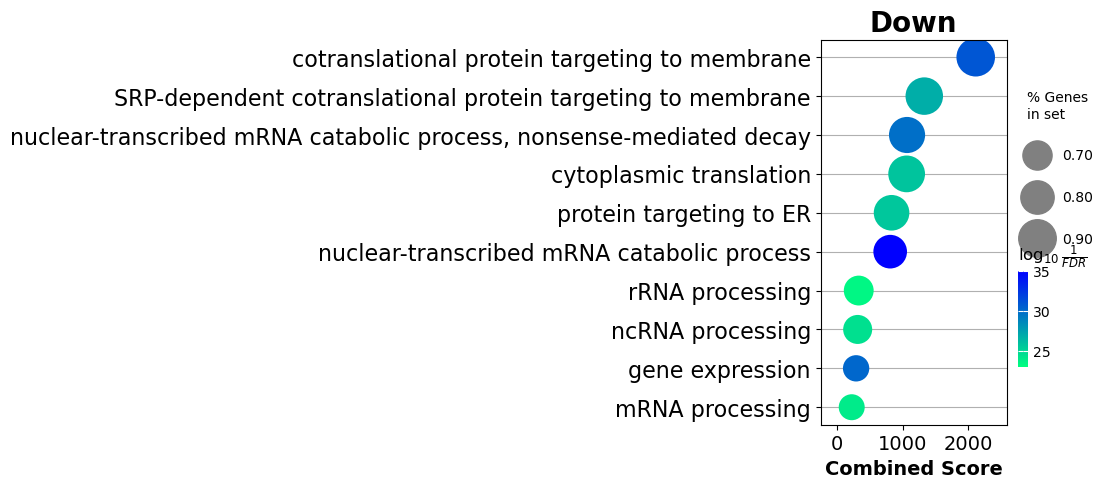

In [16]:
enr_dw.res2d.Term = enr_dw.res2d.Term.str.split(" \(GO").str[0]
gp.dotplot(enr_dw.res2d,
           figsize=(3,5),
           title="Down",
           cmap = plt.cm.winter_r,
           size=5)
plt.show()

/home/ouyangkang/software/miniconda3/envs/sc/lib/python3.11/site-packages/gseapy/plot.py:694: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(
/home/ouyangkang/software/miniconda3/envs/sc/lib/python3.11/site-packages/gseapy/plot.py:694: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[self.colname].replace(


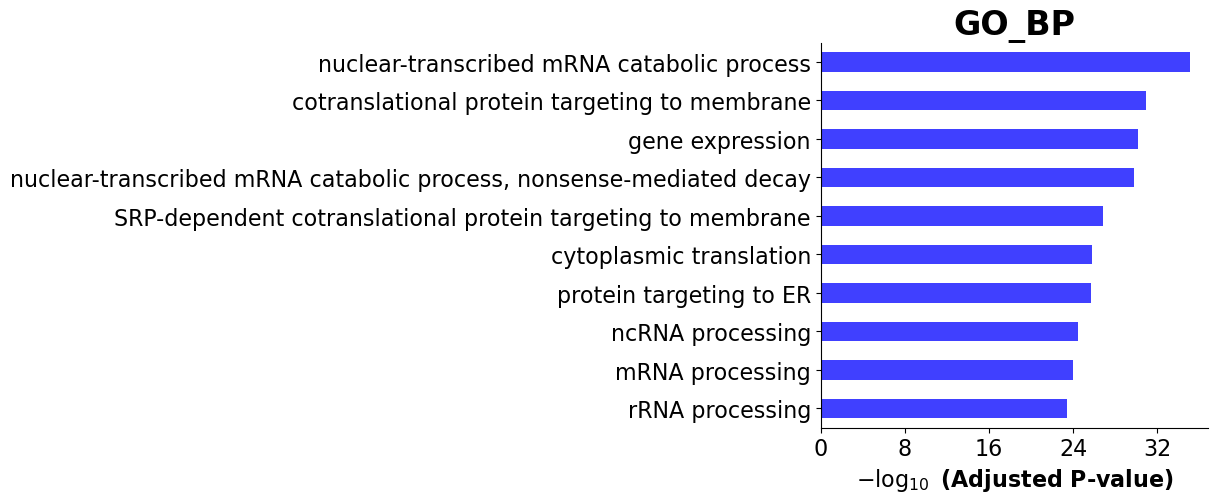

In [17]:
ax = gp.barplot(enr_dw.res2d, figsize=(5,5),
                # group ='DW',
                title ="GO_BP",
                color = "blue")

In [26]:
select_list = [enr_dw.res2d.Term[216], enr_dw.res2d.Term[277], enr_dw.res2d.Term[293], enr_dw.res2d.Term[310], enr_dw.res2d.Term[372], enr_dw.res2d.Term[399], enr_dw.res2d.Term[415], enr_dw.res2d.Term[453], enr_dw.res2d.Term[480], enr_dw.res2d.Term[541]]
enr_dw.res2d = enr_dw.res2d[enr_dw.res2d["Term"].isin(select_list)]

/home/ouyangkang/software/miniconda3/envs/sc/lib/python3.11/site-packages/gseapy/plot.py:694: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(
/home/ouyangkang/software/miniconda3/envs/sc/lib/python3.11/site-packages/gseapy/plot.py:694: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[self.colname].replace(


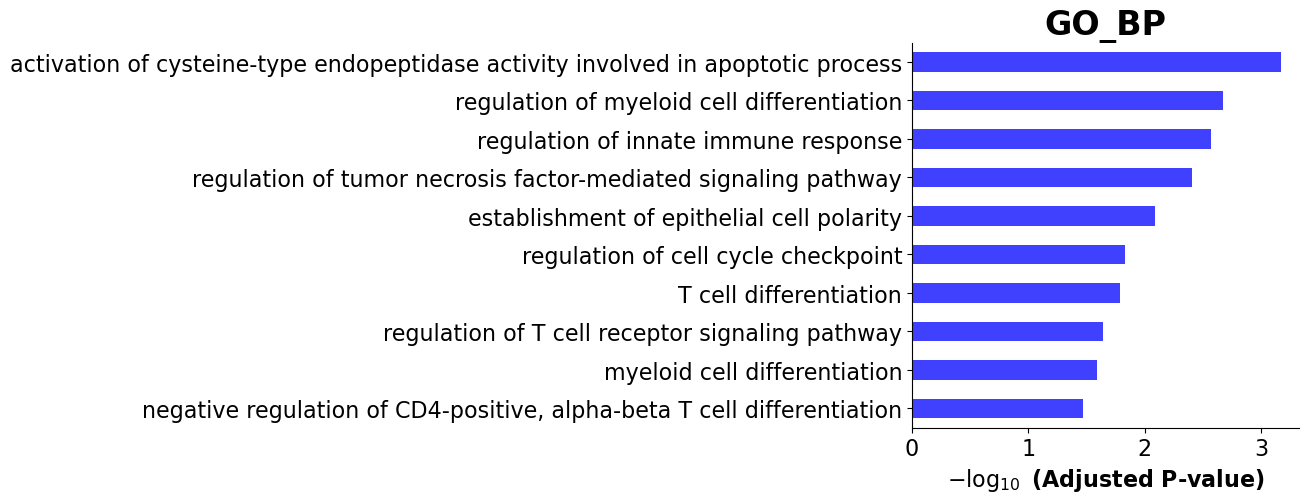

In [27]:
ax = gp.barplot(enr_dw.res2d, figsize=(5,5),
                # group ='DW',
                title ="GO_BP",
                color = "blue")

In [18]:
enr_dw.res2d.to_csv("/mnt/c/Users/ouyangkang/Desktop/T_comparison_result.csv", index=None)

In [19]:
import time
t1 = time.time()
# NOTE: To speed up, use gp.prerank instead with your own ranked list.
res = gp.gsea(data=neutrophils.to_df().T, # row -> genes, column-> samples
        gene_sets="GO_Biological_Process_2023",
        cls=neutrophils.obs.category,
        permutation_num=1000,
        permutation_type='phenotype',
        outdir=None,
        method='s2n', # signal_to_noise
        threads= 16)
t2=time.time()
print(t2-t1)

2024-07-25 22:08:53,219 [WARNING] Input data contains NA, filled NA with 0
/home/ouyangkang/software/miniconda3/envs/sc/lib/python3.11/site-packages/gseapy/gsea.py:110: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df_std = df.groupby(by=cls_dict, axis=1).std(numeric_only=True, ddof=0)
/home/ouyangkang/software/miniconda3/envs/sc/lib/python3.11/site-packages/gseapy/gsea.py:116: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df_std.abs().sum(axis=1) > 0]


7.814635753631592


In [20]:
res.res2d.head(10)

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,gsea,Positive Regulation Of Programmed Cell Death (...,-0.472034,-1.386745,0.158954,1.0,0.486688,14/15,45.46%,SCIN;CLIP3;PHLDA3;PNMA3;IGF2BP1;NOS2;BMP2;PIP5...
1,gsea,Anterograde Trans-Synaptic Signaling (GO:0098916),0.316118,1.090901,0.423077,1.0,0.588,15/25,31.71%,HTR2A;GLRB;DOC2A;SLC12A5;SLC6A1;SYN2;GRIN1;GRM...
2,gsea,Protein Ubiquitination (GO:0016567),0.328562,1.061746,0.406439,1.0,0.6,13/16,51.11%,NHLRC1;TRIM50;TRIM69;ASB11;UBE2C;MKRN4P;TRIM26...
3,gsea,Positive Regulation Of Cell Population Prolife...,0.251038,0.969675,0.528571,1.0,0.645,38/41,68.89%,NTF3;LAMC2;FGF5;EFNB2;PTN;PDGFA;FGF2;CXCL5;IGF...
4,gsea,Positive Regulation Of Cellular Process (GO:00...,0.243065,0.957299,0.534021,1.0,0.652,44/48,68.86%,NTF3;LAMC2;FGF5;EFNB2;PTN;PDGFA;FGF2;CXCL5;IGF...
5,gsea,Regulation Of Neuron Projection Development (G...,0.2651,0.938361,0.573705,1.0,0.665,20/24,58.79%,EFNB2;PLK5;PTN;KIF1A;RTN4R;NDRG4;TNN;FUT9;RTN4...
6,gsea,Negative Regulation Of Transmembrane Receptor ...,-0.301744,-0.933326,0.550403,1.0,0.726305,15/16,63.10%,SPRED3;VWC2L;IL17RD;CHRDL1;ASPN;BMP2;PEG10;SPR...
7,gsea,Chemical Synaptic Transmission (GO:0007268),0.258378,0.930039,0.54878,1.0,0.671,18/33,31.71%,HTR2A;GLRB;DOC2A;SLC12A5;SLC6A1;SYN2;GRIN1;GAB...
8,gsea,Negative Regulation Of Transcription By RNA Po...,0.256887,0.919135,0.581109,1.0,0.677,29/31,69.13%,TBX6;NR2F1;ZGLP1;SDR16C5;TRO;HES1;BHLHE41;ZNF5...
9,gsea,Positive Regulation Of Apoptotic Process (GO:0...,-0.287262,-0.912901,0.550696,1.0,0.744409,13/17,45.46%,SCIN;CLIP3;PHLDA3;PNMA3;IGF2BP1;BMP2;PIP5KL1;E...


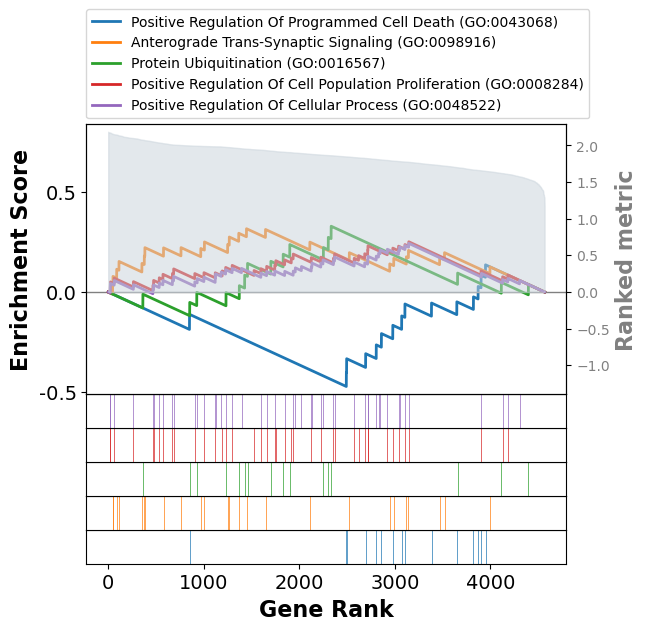

In [21]:
term = res.res2d.Term
# gp.gseaplot(res.ranking, term=term[i], **res.results[term[i]])
axs = res.plot(terms=term[:5])

In [22]:
import networkx as nx

In [25]:
nodes, edges = gp.enrichment_map(res.res2d, cutoff=0.5)

ValueError: Warning: No enrich terms when cutoff = 0.5

In [28]:
data = pd.read_csv("/mnt/c/Users/ouyangkang/Desktop/副本V2投递 - 副本.csv")

In [29]:
data

,#ProjectID,SubProjectID,SampleID,LibraryID,FQ1,FQ2,Mark,InsertSize,SubSampleID
0,P24Z31300N0042,P21Z10200N0090,BCcancer23_A2,BCcancer23_A2,/zfssz3/ST_SUPERCELLS/P21Z10200N0090/jiazihan/...,/zfssz3/ST_SUPERCELLS/P21Z10200N0090/jiazihan/...,1,500,cDNA
1,P24Z31300N0042,P21Z10200N0090,BCcancer23_A2,BCcancer24_A2,/zfssz3/ST_SUPERCELLS/P21Z10200N0090/jiazihan/...,/zfssz3/ST_SUPERCELLS/P21Z10200N0090/jiazihan/...,1,500,cDNA
2,P24Z31300N0042,P21Z10200N0090,BCcancer23_A2,BCcancer24_A2,/zfssz3/ST_SUPERCELLS/P21Z10200N0090/jiazihan/...,/zfssz3/ST_SUPERCELLS/P21Z10200N0090/jiazihan/...,1,500,cDNA
3,P24Z31300N0042,P21Z10200N0090,BCcancer23_A2,BCcancer24_A2,/zfssz3/ST_SUPERCELLS/P21Z10200N0090/jiazihan/...,/zfssz3/ST_SUPERCELLS/P21Z10200N0090/jiazihan/...,1,500,cDNA
4,P24Z31300N0042,P21Z10200N0090,BCcancer23_A2,BCcancer24_A2,/zfssz3/ST_SUPERCELLS/P21Z10200N0090/jiazihan/...,/zfssz3/ST_SUPERCELLS/P21Z10200N0090/jiazihan/...,1,500,Oligo
5,P24Z31300N0042,P21Z10200N0090,BCcancer24_B2,BCcancer24_B2,/zfssz3/ST_SUPERCELLS/P21Z10200N0090/jiazihan/...,/zfssz3/ST_SUPERCELLS/P21Z10200N0090/jiazihan/...,2,500,cDNA
6,P24Z31300N0042,P21Z10200N0090,BCcancer24_B2,BCcancer24_B2,/zfssz3/ST_SUPERCELLS/P21Z10200N0090/jiazihan/...,/zfssz3/ST_SUPERCELLS/P21Z10200N0090/jiazihan/...,2,500,cDNA
7,P24Z31300N0042,P21Z10200N0090,BCcancer24_B2,BCcancer24_B2,/zfssz3/ST_SUPERCELLS/P21Z10200N0090/jiazihan/...,/zfssz3/ST_SUPERCELLS/P21Z10200N0090/jiazihan/...,2,500,cDNA
8,P24Z31300N0042,P21Z10200N0090,BCcancer24_B2,BCcancer24_B2,/zfssz3/ST_SUPERCELLS/P21Z10200N0090/jiazihan/...,/zfssz3/ST_SUPERCELLS/P21Z10200N0090/jiazihan/...,2,500,cDNA
9,P24Z31300N0042,P21Z10200N0090,BCcancer24_B2,BCcancer24_B2,/zfssz3/ST_SUPERCELLS/P21Z10200N0090/jiazihan/...,/zfssz3/ST_SUPERCELLS/P21Z10200N0090/jiazihan/...,2,500,Oligo


In [30]:
data.to_csv("submition_script.tsv", sep="\t", index=None)